# PS3: Data-Driven Minimum-Variance Portfolio Allocation for Risky Assets
In this problem set, we'll compute the [Efficient Frontier](https://en.wikipedia.org/wiki/Efficient_frontier) for a portfolio of risky assets, where the expected return and the covariance of the returns are calculated from a historical dataset. You will then simulate the performance of the minimum-variance portfolio on out-of-sample data.

> __Learning Objectives:__
> 
> By the end of this example, you will be able to:
> 
> * **Compute empirical portfolio statistics from historical data and formulate Markowitz optimization problems.** Extract expected returns and covariance matrices from market data, then set up constrained quadratic optimization problems that minimize portfolio risk for given return targets using the classical mean-variance framework to find optimal asset allocations.
> * **Generate and analyze efficient frontier curves for risky asset portfolios.** Systematically compute optimal portfolios across different risk-return combinations and visualize the resulting efficient frontier to understand the trade-offs between expected return and portfolio volatility in the context of diversification benefits.
> * **Simulate portfolio performance using multi-asset stochastic models.** Implement geometric Brownian motion simulations to generate sample price trajectories for multiple correlated assets, enabling out-of-sample testing of minimum-variance portfolios against market benchmarks and evaluation of strategy robustness under uncertainty.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

>__Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [151]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2025` until `09-26-2025`, along with data for several exchange-traded funds and volatility products during that time period.

Let's load the `original_dataset::DataFrame` by calling [the `MyTestingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTestingMarketDataSet).

In [152]:
original_dataset = MyTestingMarketDataSet() |> x-> x["dataset"] # load the original dataset (testing)

Dict{String, DataFrame} with 482 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  ⋮      => ⋮

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days to ensure we have consistent, complete time series for reliable analysis.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [153]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [154]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Next, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [155]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

In [156]:
list_of_tickers

476-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 ⋮
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBH"
 "ZBRA"
 "ZION"
 "ZTS"

Now, let's load the GBM parameters that we computed in the previous example:

In [157]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end;

Next, let's load the covariance matrix that we computed in the previous example:

In [158]:
covariance_dictionary = let

    # initialize -
    path_to_covariance = joinpath(_PATH_TO_DATA,"Covariance-Return-Training-Fall-2025.jld2");
    covariance = JLD2.load(path_to_covariance);
    covariance;
end;

### Constants and Parameters
Let's define some constants and parameters that we will use in our simulations. See the comments next to each constant for additional information, including values, units, etc.

In [159]:
Δt = (1.0/252.0); # time step (1 trading day, in years)
TSIM = 182; # number of trading days to simulate (1 quarter, in trading days)
all_range = range(1,stop=maximum_number_trading_days,step=1) |> collect;
startdate = Date(2025,1,1); # start date of simulation
risk_free_rate = 0.03815; # benchmark: 10-year T-note 10/03/24
total_initial_investment = 1000; # total initial investment amount (USD)

## Task 1: Build the log return array and covariance matrix for a sample portfolio
Modern portfolio theory requires two key inputs: expected returns and the covariance structure between assets. In this task, we will extract these statistics from our historical dataset to prepare for optimization.

We will compute the expected growth (return) vector (we'll approximate this using the drift vector) and the covariance matrix for the assets in a portfolio composed of $M$ risky assets that we choose. Thus, before we compute the efficient frontier, we must decide which tickers to include in the risky portfolio. 

> __Ticker picker question:__ Which assets to include in your portfolio may seem like a simple question, but it turns out to be a hard question to answer, and it can have a __significant impact__ on the performance of your portfolio. There are so many interesting threads that we could pull here. But for now, just pick something. 

Specify a collection of ticker symbols, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_list_of_tickers::Array{String,1}` array. 

In [160]:
# TODO: Select at LEAST 3 tickers. We have some random tickers that I selected.
# Reminder: Only use tickers that are in the dataset above, and we have parameters for them
# If you choose tickers that are not in the dataset, you will get errors!
my_list_of_tickers = ["AAPL", "MSFT", "INTC", "MU", "AMD", "NVDA","GS", "BAC", "WFC", "C", "F", "GM", "JNJ"]; # list of tickers to include in the portfolio

Now that we have selected the firms in our risky portfolio, we'll compute the firm-specific expected return vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. 

In [161]:
μ̂, Σ̂ᵣ = let

    # initialize -
    M = length(my_list_of_tickers); # number of assets in portfolio
    μ = Array{Float64,1}(); # drift vector
    Σᵣ = Array{Float64,2}(undef, M, M); # covariance matrix for *our* portfolio
    tickers_in_parameters = parameters_df[:, :ticker] |> collect; # list of tickers in parameters_df
    covariance_ticker_list = covariance_dictionary["list_of_tickers"] |> collect; # list of tickers in covariance dictionary
    Σ = covariance_dictionary["covariance_matrix"]; # full covariance matrix

    # compute drift vector -
    for ticker ∈ my_list_of_tickers
        i = findfirst(x-> x == ticker, tickers_in_parameters); # find index of ticker in the parameters_df
        push!(μ, parameters_df[i, :drift]); # append drift value to μ
    end

    # compute covariance matrix -
    for i ∈ 1:M
        for j ∈ 1:M
            row_index = findfirst(x-> x == my_list_of_tickers[i], covariance_ticker_list); # find row index in full covariance matrix
            col_index = findfirst(x-> x == my_list_of_tickers[j], covariance_ticker_list); # find column index in full covariance matrix
            Σᵣ[i,j] = Σ[row_index, col_index]; # assign value to Σᵣ
        end
    end

    (μ, Σᵣ); # return
end;

## Task 2: Compute the efficient frontier for your collection of stocks
With our expected returns and covariance matrix in hand, we can now solve the classic Markowitz optimization problem. This will give us the set of portfolios that offer the highest expected return for each level of risk.

In this task, we'll compute the optimal allocation in the minimum variance sense using the tickers in the `my_list_of_tickers::Array{String,1}` vector.

> __What are we going to do?__ Create an instance of the [MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem), and store this in the `problem_risk` variable using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem},%20NamedTuple}). You'll need to pass your covariance array $\hat{\Sigma}_{r}$, the expected return array $\hat{\mu}_{r}$, along with bounds and an initial guess, to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem},%20NamedTuple}). Then, we can use the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) for different values of the minimum desired return to compute the efficient frontier.

First, let's set up the bounds and other parameters required for the computation of the portfolio weights along the efficient frontier:

In [162]:
number_of_firms = length(my_list_of_tickers); # how many firms do we have
wₒ = zeros(number_of_firms) # initial allocation (zeros)
wₒ[1] = 1.0; # all money in firm 1
bounds = zeros(number_of_firms,2); 
bounds[:,2] .= 1.0;
number_of_points = 201;

Next, let's build an instance of the [MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem) using the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem},%20NamedTuple}), passing in the data for the required fields:

In [163]:
# TODO: Build the portfolio choice problem instance
problem_risk = build(MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem, (Σ=Σ̂ᵣ, μ=μ̂, bounds=bounds, initial=wₒ, R=0.0)); 

Now, create an array holding the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable. In this example, let's start at `0` and go up to `20`$\times{r_{f}}$ annualized return using `number_of_points`:

In [164]:
# TODO: Uncomment the line below to build the desired return that our portfolio should achieve
minimum_desired_reward_array = range(0.0, stop = 20*risk_free_rate, length = number_of_points) |> collect; # R

What's in the `minimum_desired_reward_array::Array{Float64,1}` array?

In [165]:
minimum_desired_reward_array

201-element Vector{Float64}:
 0.0
 0.0038150000000000007
 0.007630000000000001
 0.011445000000000002
 0.015260000000000003
 0.019075
 0.022890000000000004
 0.026705000000000003
 0.030520000000000005
 0.034335000000000004
 ⋮
 0.7324800000000001
 0.7362950000000001
 0.7401100000000002
 0.7439250000000002
 0.7477400000000001
 0.7515550000000001
 0.7553700000000001
 0.7591850000000001
 0.7630000000000001

We now iterate through the `minimum_desired_reward_array::Array{Float64,1}` and compute the minimum risk required to achieve the specified reward level using a `for-loop`.

For each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier` dictionary. In particular, we store the portfolio risk as the `key` and the expected return, risk and allocation as the `value` in the `efficient_frontier` dictionary.

Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation has converged. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to converge. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [166]:
efficient_frontier = let

    # initialize -
    efficient_frontier = Dict{Float64, NamedTuple}();

    # main loop
    for i ∈ eachindex(minimum_desired_reward_array)
        problem_risk.R = minimum_desired_reward_array[i]; # update the problem object with the min desired reward value
    
        try
            solution = solve(problem_risk)
            status_flag = solution["status"];    

            if (status_flag == MathOptInterface.LOCALLY_SOLVED)
                risk_value = solution["objective_value"]; # get the sqrt of the risk -
                reward_value = solution["reward"];
                allocation = solution["argmax"]; # TODO: JV needs to update this key
                
                
                efficient_frontier[risk_value] = (risk = risk_value, reward = reward_value, w = allocation)
            end
        catch err
            # Uncomment to see which R's failed ...
            println("Failed: desired R = $(problem_risk.R). Infeasible");
        end    
    end
    efficient_frontier;
end;

Failed: desired R = 0.50358. Infeasible
Failed: desired R = 0.507395. Infeasible
Failed: desired R = 0.51121. Infeasible
Failed: desired R = 0.5150250000000001. Infeasible
Failed: desired R = 0.5188400000000001. Infeasible
Failed: desired R = 0.5226550000000001. Infeasible
Failed: desired R = 0.5264700000000001. Infeasible
Failed: desired R = 0.5302850000000001. Infeasible
Failed: desired R = 0.5341000000000001. Infeasible
Failed: desired R = 0.537915. Infeasible
Failed: desired R = 0.54173. Infeasible
Failed: desired R = 0.5455450000000001. Infeasible
Failed: desired R = 0.5493600000000001. Infeasible
Failed: desired R = 0.5531750000000001. Infeasible
Failed: desired R = 0.5569900000000001. Infeasible
Failed: desired R = 0.5608050000000001. Infeasible
Failed: desired R = 0.5646200000000001. Infeasible
Failed: desired R = 0.5684350000000001. Infeasible
Failed: desired R = 0.5722500000000001. Infeasible
Failed: desired R = 0.576065. Infeasible
Failed: desired R = 0.5798800000000001. Inf

What's in the `efficient_frontier::Dict{Float64,NamedTuple}` dictionary?

In [167]:
efficient_frontier

Dict{Float64, NamedTuple} with 132 entries:
  0.0187713 => (risk = 0.0187713, reward = 0.0924055, w = [0.0901429, 0.14233, …
  0.0256797 => (risk = 0.0256797, reward = 0.20601, w = [0.157648, 0.257247, -5…
  0.0215558 => (risk = 0.0215558, reward = 0.16786, w = [0.139627, 0.225405, 2.…
  0.0342504 => (risk = 0.0342504, reward = 0.255605, w = [0.178264, 0.296047, 5…
  0.0521466 => (risk = 0.0521466, reward = 0.324275, w = [0.206809, 0.349769, 3…
  0.0583603 => (risk = 0.0583603, reward = 0.34335, w = [0.214738, 0.364691, 2.…
  0.0454032 => (risk = 0.0454032, reward = 0.301385, w = [0.197294, 0.331861, 3…
  0.0623768 => (risk = 0.0623768, reward = 0.354795, w = [0.206233, 0.354267, 2…
  0.140339  => (risk = 0.140339, reward = 0.492135, w = [1.8003e-6, 0.0160021, …
  0.0822087 => (risk = 0.0822087, reward = 0.400575, w = [0.129256, 0.24981, 1.…
  0.0637947 => (risk = 0.0637947, reward = 0.35861, w = [0.199818, 0.345562, 2.…
  0.143309  => (risk = 0.143309, reward = 0.49595, w = [9.55808e-

### Organize efficient frontier results into a matrix for analysis and visualization
Transform the `efficient_frontier::Dict{Float64,NamedTuple}` dictionary into a matrix format for plotting and analysis.

> __What are we doing?__ Extract portfolio data from the `efficient_frontier::Dict{Float64,NamedTuple}` dictionary and organize it into the `results_array::Array{Float64,2}` matrix. Sort portfolios by risk level (small to large) and store risk, return, and allocation weights in matrix columns.

> __What's in the results array?__ The `results_array::Array{Float64,2}` has `number_of_portfolios::Int64` rows and `M+2` columns:
> * Column 1: Portfolio risk (standard deviation = √variance)  
> * Column 2: Portfolio expected return
> * Columns 3 to M+2: Asset allocation weights for the `M::Int64` tickers

Let's build the `results_array::Array{Float64,2}` from our efficient frontier solutions:

In [168]:
results_array = let

    # initialize -
    number_of_portfolios = length(efficient_frontier); # how many portfolios do we have? (these all exited correctly)
    M = length(my_list_of_tickers); # how many tickers do we have?
    results_array = Array{Float64,2}(undef, number_of_portfolios, M+2);
    risk_array_sorted = keys(efficient_frontier) |> collect |> sort;

    for i ∈ eachindex(risk_array_sorted)
        risk_value = risk_array_sorted[i] |> sqrt; # let's plot the sqrt of the risk
        
        data = efficient_frontier[risk_array_sorted[i]] # get the NamedTuple corresponding to this risk level
        reward_value = data.reward;
        w = data.w;

        # TODO: Uncomment the lines below to populate the results_array
        # The first column is risk (sorted), the second column is reward, and the remaining columns are the weights
        results_array[i,1] = risk_value;
        results_array[i,2] = reward_value;
        for j ∈ 1:M
            results_array[i,2+j] = w[j];
        end
    end

    results_array
end;

In [169]:
results_array

132×15 Matrix{Float64}:
 0.137008  0.0924053  0.0901426   0.14233      …   0.00205028   0.627754
 0.137008  0.0924055  0.0901429   0.14233          0.00205083   0.627754
 0.137008  0.0924052  0.0901423   0.14233          0.00205415   0.627754
 0.137008  0.0924052  0.0901421   0.14233          0.00205635   0.627754
 0.137008  0.0924052  0.090142    0.14233          0.00205724   0.627754
 0.137008  0.0924051  0.090142    0.14233      …   0.00205777   0.627754
 0.137008  0.0924051  0.0901419   0.14233          0.00205811   0.627754
 0.137008  0.0924051  0.0901419   0.142329         0.00205829   0.627755
 0.137008  0.0924051  0.0901419   0.142329         0.00205833   0.627755
 0.137008  0.0924051  0.0901419   0.14233          0.00205835   0.627755
 ⋮                                             ⋱               
 0.351401  0.469245   0.0137927   0.0931201        6.95473e-9   3.22476e-8
 0.35522   0.47306    0.00737565  0.0844179       -9.33622e-9  -8.36473e-9
 0.359057  0.476875   0.00104212

### Visualize the efficient frontier
Now that we have computed the optimal portfolios, let's visualize the classic risk-return trade-off that Markowitz theory reveals. The efficient frontier shows the boundary of achievable risk-return combinations for our selected assets.

`Unhide` the code block below to see how we plotted the efficient frontier for the collection of equities and ETFs specified in the `my_list_of_tickers::Array{String,1}` array.

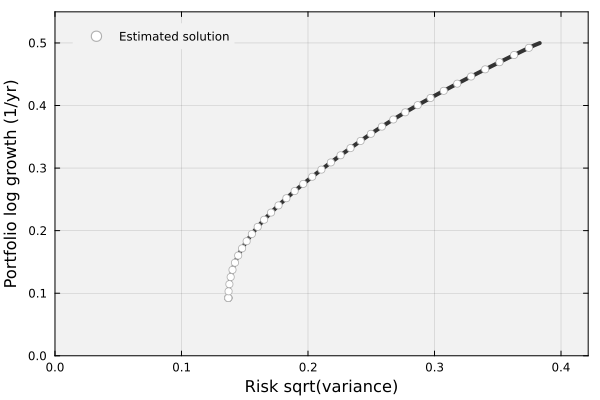

In [170]:
let

    # initialize -
    max_risk_value = results_array[end,1]; # what is the biggest risk we have (x-axis value)
    max_reward_value = results_array[end,2]; # what is the biggest reward that we have (y-axis value)
    number_of_portfolios = length(efficient_frontier); # how many portfolios did we recover?
    skip = 3;

    plot(results_array[:,1], results_array[:,2], lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio log growth (1/yr)", fontsize=18, label="", c=:gray20, 
        xlim=(0.0, 1.1*max_risk_value), ylim = (0.0, 1.1*max_reward_value))
    scatter!(results_array[1:skip:number_of_portfolios,1], results_array[1:skip:number_of_portfolios,2], 
        label="Estimated solution", c=:white, ms=4, msc=:gray69)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

In [171]:
do_I_see_minvar_plot = true; # set to {true | false} if you see the minvar plot (true = yes, false = no).

## Task 3: Simulate the performance of the minimum-variance portfolio on out-of-sample data
Now that we have computed the efficient frontier and identified the minimum-variance portfolio, we can simulate its performance on out-of-sample data using our multiple asset Geometric Brownian Motion (MAGBM) model. This will help us understand how the portfolio might perform in a real-world scenario. 

To run this simulation, we need a few things. First, which portfolio are we simulating? Let's choose the minimum-variance portfolio from our efficient frontier results. We'll extract the allocation weights for this portfolio. We'll save these weights in the `w::Array{Float64,1}` array.

In [172]:
w = let

    # initialize -
    index_to_view = 1; # TODO: change this index to view different portfolios
    w = results_array[index_to_view, 3:end] .|> x-> round(x, digits=4) |> abs; # 3:end gives the allocations
    w; # return
end;


### Compute the $\mathbf{A}$ matrix using Cholesky factorization 
We need to compute the Cholesky decomposition of the covariance matrix for the assets in our portfolio to run the MAGBM model. This will allow us to generate correlated random variables that reflect the relationships between the asset returns. Let's start there.

MAGBM factors the covariance matrix $\Sigma = \mathbf{A}\mathbf{A}^{\top}$ using a [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition) to get the $a_{ij}$ coefficients which appear in the noise term of the multi-asset geometric Brownian motion expression. We'll use the [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition) routine implemented in the [LinearAlgebra.jl package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/), which is part of the [Julia standard library](https://docs.julialang.org/en/v1/).

> __What is going on?__ We call the [cholesky function](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.cholesky) with the covariance matrix `Σ̂ᵣ` as an argument. This returns the matrix factorization in the [Cholesky type](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.Cholesky), which has the `L` and `U` fields, holding the `lower` and `upper` triangular factorizations, respectively. We convert the `lower` triangular factor into a [Matrix type](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix) so that we can do computations with it later. We store this matrix in the variable $\mathbf{A}$, where the coefficients $a_{ij}\in\mathbf{A}$.

So what do we get?

In [173]:
A,Ā = let 
    factors = cholesky(Σ̂ᵣ);
    A = factors.L |> x-> Matrix(x)
    Ā = diagm(0 => diag(A))
    (A, Ā)
end;

#### Check: Is the Cholesky factorization legit?
Before we use the [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition) in our multi-asset simulation, let's check that we can recover the original firm-specific covariance matrix `Σ̂ᵣ`. We know that $\mathbf{A}\mathbf{A}^{\top} = \Sigma$, so let's compare `Σ̂ᵣ` and the matrix product $\mathbf{A}\mathbf{A}^{\top}$ using the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) in combination with the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) with `rtol = 1e-6` (or you can choose some other random small value).
> __Test__ If the `Σ̂ᵣ` and the matrix product $\mathbf{A}\mathbf{A}^{\top}$ are `NOT` close, i.e., the difference between them is larger than the absolute tolerance `atol` value, the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) will evaluate to `false` and the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) will throw an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError). Otherwise, nothing happens (which is good).

Did we pass the test? If you did not get an error, then yes!

In [174]:
@assert isapprox(Σ̂ᵣ, A*transpose(A), atol = 1e-6)

Next, let's grab the initial prices for the assets in our portfolio from the `dataset::Dict{String,DataFrame}` dictionary. We'll store these initial prices in the `Sₒ::Array{Float64,1}` array.

In [175]:
Sₒ = let

    # initialize -
    Sₒ = Array{Float64,1}(); # initial stock prices vector

    # TODO: Uncomment the lines below to populate the initial stock prices vector Sₒ
    # We iterate throough the list of tickers and get the opening price on day 1
    # We use the push! function to append values to the Sₒ array
    for ticker ∈ my_list_of_tickers
        data = dataset[ticker]; # get the data for the ticker
         price = data[1, :open]; # get the first opening price (we buy at the open of day 1)
         push!(Sₒ, price); # append to Sₒ
     end

    
    Sₒ; # return
end;

How much of each asset do we purchase in our minimum-variance portfolio? We can compute this from the initial investment amount and the allocation weights.

> __Initial share calculation:__ The number of shares purchased for each asset in the minimum-variance portfolio is calculated by multiplying the total initial investment budget ($B$) by the allocation weight for each asset, and then dividing by the initial price of that asset, which we denote as $S^{(i)}_{0}$. This gives us the number of shares we can afford to buy with our allocated funds for each asset, or:
> $$
\begin{align*}
N_i &= \frac{w_i\;B}{S^{(i)}_{0}} \\
\end{align*}
$$ 

Let's compute the initial number of shares purchased for each asset in our minimum-variance portfolio, we'll store these values in the `Nₒ::Array{Float64,1}` array:

In [176]:
Nₒ = let
    
    # initialize -
    total_budget = total_initial_investment; # total initial investment amount (USD)
    Nₒ = Array{Float64,1}()

    # TODO: Uncomment the lines below to compute the number of shares for each asset (assuming we can buy fractional shares, and the price is Sₒ)
    # We iterate through each weight wᵢ, compute the number of shares nᵢ = (wᵢ * total_budget) / Sₒ[i], and append to Nₒ
    for i ∈ eachindex(w)
         wᵢ = w[i] # get the weight for asset i
         nᵢ = (wᵢ*total_budget)/Sₒ[i]; # compute number of shares for asset i
         push!(Nₒ,nᵢ) # append to the Nₒ array
     end

    Nₒ; # return
end;

Let's make a table to summarize our initial investment [using the `pretty_table(...)` function exported by the `PrettyTables.jl` package](https://github.com/ronisbr/PrettyTables.jl).

In [177]:
let

    # initialize -
    total_budget = total_initial_investment; # total initial investment amount (USD)
    df = DataFrame();

    for (i, ticker) ∈ enumerate(my_list_of_tickers)
        Sₒᵢ = Sₒ[i]
        wᵢ = w[i]
        nᵢ = Nₒ[i]
        total_investmentᵢ = wᵢ*total_budget
        temp_df = (Ticker = ticker, Initial_Price = Sₒᵢ, Allocation_w = wᵢ, Number_of_Shares = nᵢ, Total_Investment = total_investmentᵢ);
        df = push!(df, temp_df);
    end

    # build a table -
    pretty_table(df, backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact))

end

 -------- --------------- -------------- ------------------ ------------------
  Ticker   Initial_Price   Allocation_w   Number_of_Shares   Total_Investment 
  String         Float64        Float64            Float64            Float64 
 -------- --------------- -------------- ------------------ ------------------
    AAPL          243.36         0.0901           0.370233               90.1
    MSFT          421.08         0.1423           0.337941              142.3
    INTC           20.39          0.041            2.01079               41.0
      MU           87.95            0.0                0.0                0.0
     AMD          121.65            0.0                0.0                0.0
    NVDA          140.01            0.0                0.0                0.0
      GS           581.0         0.0236          0.0406196               23.6
     BAC           44.75            0.0                0.0                0.0
     WFC           70.35         0.0595           0.845771  

In [178]:
do_I_see_the_ticker_setup_table = true; # set to {true | false} if you see the ticker setup table (true = yes, false = no).

### Run the multi-asset simulation to compute the share price trajectories
Building on the single asset case, we construct an instance of [the `MyMultipleAssetGeometricBrownianMotionEquityModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyMultipleAssetGeometricBrownianMotionEquityModel), where we pass the drift vector $\mu$ and the factored covariance matrix $\mathbf{A}$ into [a `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMultipleAssetGeometricBrownianMotionEquityModel},%20NamedTuple}):

In [179]:
# TODO: Build the GBM model instance using a build method
multiasset_model = build(MyMultipleAssetGeometricBrownianMotionEquityModel, (A=A, μ=μ̂)); 

Then we pass the start time `T₁`, the stop time `T₂` for the simulation, the initial conditions `Sₒ`, the time step `Δt`, and other simulation parameters along with the `model` instance into the `sample(...)` function. This function computes `number_of_paths` sample paths and returns the simulated data in the `simulation_dictionary` variable.

The `simulation_dictionary` data structure holds a simulation array for each sample path, where the simulation array has time in the first column and the simulated price for each asset in columns $2\dots\dim\mathcal{L}$. Each row is a time value; there will be `T+1` rows for each simulation array.

In [180]:
simulation_dictionary = let
    
    # initialize -
    start_index = 1;
    stop_index = TSIM + start_index - 1;
    number_of_trials = 250; # number of sample paths to compute

    # specify the time range -
    T₁ = start_index*Δt # start time (in years)
    T₂ = stop_index*Δt # end time (in years)

    # run the simulation -
    simulation_dictionary = VLQuantitativeFinancePackage.sample(multiasset_model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
        number_of_paths = number_of_trials);

    simulation_dictionary; # return 
end;

#### Compute the simulated wealth of portfolio $\mathcal{P}$ given our allocation
`Unhide` the code block below to see how we computed the __simulated wealth__ of the portfolio $\mathcal{P}$ for the allocation specified above. We store the simulation data in the `simulated_wealth_array::Array{Float64,2}` variable.

> __What's in the simulated wealth array?__ Each column in the `simulated_wealth_array` corresponds to a sample path from the multi-asset GBM simulation. Each row corresponds to a time value. The entries in the array are the total wealth of the portfolio $\mathcal{P}$ at each time for each sample path.

Let's compute the simulated wealth of our portfolio $\mathcal{P}$.

In [181]:
simulated_wealth_array = let

    # initialize -
    number_of_trials = length(simulation_dictionary) # number of trials
    number_of_days = simulation_dictionary[1] |> m -> size(m,1) # number of days in each trial
    M = length(my_list_of_tickers); # number of assets in portfolio
    simulated_wealth_array = Array{Float64,2}(undef, number_of_days, number_of_trials);
   
    # compute the wealth for each trial 
    for i ∈ 1:number_of_trials
        
        simulation_array = simulation_dictionary[i]
        
        portfolio_performance_array = Array{Float64,2}(undef, number_of_days, M+1)
        for j ∈ eachindex(my_list_of_tickers)
        
            ticker = my_list_of_tickers[j];
            price_data = simulation_array[:,j+1];
            nⱼ = Nₒ[j]
        
            for k ∈ 1:number_of_days
                portfolio_performance_array[k,j] = nⱼ*price_data[k];
            end
        end
    
        # total -
        for j ∈ 1:number_of_days
            portfolio_performance_array[j,end] = sum(portfolio_performance_array[j,1:end-1])
        end
        
        # wealth -
        for j ∈ 1:number_of_days
            simulated_wealth_array[j,i] = portfolio_performance_array[j,end];
        end
    end
    simulated_wealth_array;
end;

#### Compute the __actual wealth__ of portfolio $\mathcal{P}$ given our allocation
`Unhide` the code block below to see how we computed the __actual wealth__ of the portfolio $\mathcal{P}$ for the allocation specified above. We store the simulation data in the `actual_portfolio_performance_array::Array{Float64,2}` variable.

> __What's in the actual wealth array?__ Each row in the `actual_portfolio_performance_array` corresponds to a time value. The entries in the array are the total wealth of the portfolio $\mathcal{P}$ at each time for the actual market data.

Let's compute the actual wealth of our portfolio $\mathcal{P}$.

In [182]:
actual_portfolio_performance_array = let


    # initialize -
    number_of_trials = length(simulation_dictionary) # number of trials
    number_of_days = simulation_dictionary[1] |> m -> size(m,1) # number of days in each trial
    M = length(my_list_of_tickers); # number of assets in portfolio
    actual_portfolio_performance_array = Array{Float64,2}(undef, number_of_days, M+1)
    
    # compute the wealth for each trial
    for i ∈ eachindex(my_list_of_tickers)
        
        ticker = my_list_of_tickers[i];
        price_df = dataset[ticker];
        ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
        nᵢ = Nₒ[i]
        
        for j ∈ 1:number_of_days
            actual_portfolio_performance_array[j,i] = nᵢ*ticker_data[j,:volume_weighted_average_price];
        end
    end
    
    # total -
    for i ∈ 1:number_of_days
        actual_portfolio_performance_array[i,end] = sum(actual_portfolio_performance_array[i,1:end-1])
    end
    actual_portfolio_performance_array;
end;

### Compute the wealth of an index portfolio
An alternative to building a portfolio of risky assets is to invest in an index fund that tracks a market index, such as the S&P 500. Let's use the [SPY ETF](https://en.wikipedia.org/wiki/SPDR_S%26P_500) as a proxy for the S&P 500 index, and compute our wealth if we had invested our entire `total_budget` in the SPY ETF at the start of our investment period.

> __What's in the benchmark wealth array?__ The `benchmark_wealth_array` is a one-dimensional array where each entry corresponds to the total wealth of the benchmark portfolio (SPY ETF) at each time value during the investment period. Here we are assuming we invested our entire `total_budget` in the SPY ETF at the start of the investment period.

Let's compute the benchmark wealth array.

In [183]:
benchmark_wealth_array = let

    # initialize -
    total_budget = total_initial_investment; # total initial investment amount (USD)
    spy_data = dataset["SPY"];
    spy_data = filter(:timestamp => x-> x >= startdate, spy_data)
    number_of_days = size(spy_data,1)
    benchmark_wealth_array = Array{Float64,2}(undef, number_of_days, 1)

    # compute the wealth -
    for i ∈ 1:number_of_days
        benchmark_wealth_array[i,1] = (total_budget/spy_data[1,:open])*spy_data[i,:volume_weighted_average_price];
    end
    benchmark_wealth_array;
end;

### Visualize simulated, actual and benchmark wealth arrays
`Unhide` the code block below to see how we plotted the performance of the __simulated__ and __actual__ portfolio $\mathcal{P}$ with our allocation $\mathbf{w}$, along with the benchmark performance of the SPY ETF.

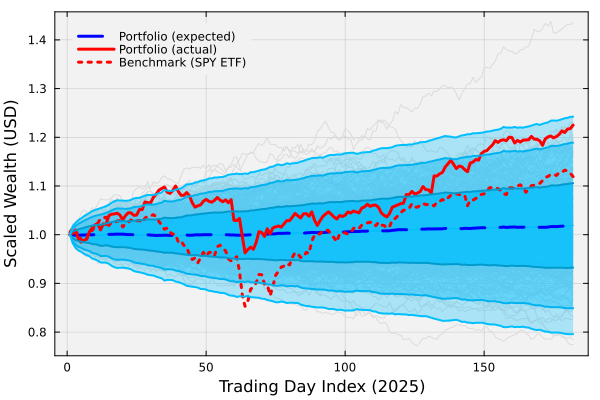

In [184]:
let

    # initialize -
    total_budget = total_initial_investment; # total initial investment amount (USD)
    number_of_trials = length(simulation_dictionary) # number of trials
    p = plot(); # initialize an empty plot
    
    # plot the trajectories -
    for i ∈ 1:number_of_trials
        plot!((1/total_budget)*simulated_wealth_array[:,i], c=:gray86,lw=1, label="")
    end
    
    # compute the expected wealth array, and bounds 0
    expected_wealth_array = mean(simulated_wealth_array,dims=2)
    L68 = (1/total_budget)*(expected_wealth_array .- std(simulated_wealth_array,dims=2))
    U68 = (1/total_budget)*(expected_wealth_array .+ std(simulated_wealth_array,dims=2))
    plot!((1/total_budget)*expected_wealth_array,fillrange=L68, c=:deepskyblue1, alpha=0.75,label="")
    plot!((1/total_budget)*expected_wealth_array,fillrange=U68, c=:deepskyblue1, alpha=0.75, label="")
    
    L95 = (1/total_budget)*(expected_wealth_array .- 1.96*std(simulated_wealth_array,dims=2))
    U95 = (1/total_budget)*(expected_wealth_array .+ 1.96*std(simulated_wealth_array,dims=2))
    plot!((1/total_budget)*expected_wealth_array,fillrange=L95, c=:deepskyblue1, alpha=0.40,label="")
    plot!((1/total_budget)*expected_wealth_array,fillrange=U95, c=:deepskyblue1, alpha=0.40, label="")

    L99 = (1/total_budget)*(expected_wealth_array .- 2.576*std(simulated_wealth_array,dims=2))
    U99 = (1/total_budget)*(expected_wealth_array .+ 2.576*std(simulated_wealth_array,dims=2))
    plot!((1/total_budget)*expected_wealth_array,fillrange=L99, c=:deepskyblue1, alpha=0.30,label="")
    plot!((1/total_budget)*expected_wealth_array,fillrange=U99, c=:deepskyblue1, alpha=0.30, label="")
    
    plot!((1/expected_wealth_array[1]).*expected_wealth_array, ls=:dash, c=:blue, lw=3, label="Portfolio (expected)")
    plot!((1/actual_portfolio_performance_array[1,end]).*actual_portfolio_performance_array[:,end], lw=3, 
        c=:red, label="Portfolio (actual)")

    # plot the benchmark -
    plot!((1/total_budget)*benchmark_wealth_array, lw=3, ls=:dot, c=:red, label="Benchmark (SPY ETF)")

    plot!(L68, c=:deepskyblue3, lw=2, label="")
    plot!(U68, c=:deepskyblue3, lw=2, label="")
    plot!(L95, c=:deepskyblue2, lw=2, label="")
    plot!(U95, c=:deepskyblue2, lw=2, label="")
    plot!(L99, c=:deepskyblue1, lw=2, label="")
    plot!(U99, c=:deepskyblue1, lw=2, label="")
    
    
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    
    xlabel!("Trading Day Index (2025)", fontsize=18)
    ylabel!("Scaled Wealth (USD)", fontsize=18)
    current()
end

In [185]:
do_I_see_the_final_wealth_plot = true; # set to {true | false} if you see the final wealth plot (true = yes, false = no).

___

## Discussion Questions

### Question 1: Portfolio Composition and the Efficient Frontier Trade-off
Change the `index_to_view::Int` value to analyze three distinct portfolios along the efficient frontier: the minimum-variance portfolio (lowest risk), a medium-risk portfolio (approximately middle of the frontier), and the maximum-return portfolio (highest risk-return point).

__Discuss:__ How does the composition of the portfolio change as you move from minimum variance to maximum return? Which assets become more or less prominent, and why might this happen based on the individual asset characteristics (hint: look at the expected returns in $\hat{\mathbf{\mu}}$ and the variance terms on the diagonal of $\hat{\mathbf{\Sigma}}_{r}$ for each asset)? What does this tell you about the trade-off between diversification and concentration as risk tolerance increases?

__TODO__: As risk tolerance goes from the minimum variance portfolio to the maximum return portfolio, there is a shift in the portfolio composition. At low variance, where risk tolerance is low, the portfolio places more weight on the assets with low individual variance and low correlations with one another. These assets won't have high expected returns, but they are still important because they stabilize the portfolio increase diversification. Towrds the middle, where there is moderate risk tolerance, the portfolio starts to include assets with higher expected returns, while still maintaining diversification to control overall variance. With a maximum return portfolio, risk tolerance is high, and the portfolio becomes highly concentrated with assets with the largest expected returns, even if these assets have high individual variances or are strongly correlated with others. This shows the trade-off between diversification and concentration where at low risk tolerance, diversification is important in minimizing volatility, and at high risk tolerance, there is reduced diversification and increased assets with high expected return.

In [186]:
did_I_answer_DQ1 = true; # change this to {true | false} if you answered DQ1 (true = yes, false = no)

### Question 2: Out-of-Sample Performance and Model Limitations
Compare the performance of your minimum-variance portfolio against the SPY ETF benchmark by analyzing the visualization from the final plot. Consider both the simulated (blue confidence bands) and actual (red line) performance trajectories.

__Discuss:__ Did the minimum-variance portfolio outperform or underperform the SPY benchmark during the out-of-sample period? What does the relationship between the actual portfolio performance and the simulated confidence intervals tell you about the reliability of the historical parameter estimates ($\hat{\mu}$ and $\hat{\mathbf{\Sigma}}_{r}$)? 

* If the actual performance fell outside the 99% confidence bands, what might this suggest about the limitations of using historical data to predict future portfolio behavior? Consider factors such as parameter estimation error, regime changes, or non-stationarity in the underlying asset dynamics.

__TODO__: The minimum-variance portfolio slightly outperformed the SPY benchmark during the out-of-sample period, since it has a higher final scaled wealth on the graph. The actual portfolio performance mostly stayed within the simulated confidence intervals, which says that the historical estimates of expected returns and covariances were relatively reliable and that the portfolio behaved mostly as predicted based on the historical data. However, if the actual performance had fallen outside the 99% confidence interval, this would imply that the model’s assumptions were unreliable due to parameter estimation errors, market regime changes, or non-stationarity in asset dynamics. These deviations highlight the limitations of using historical data to forecast future performance.

In [187]:
did_I_answer_DQ2 = true; # change this to {true | false} if you answered DQ1 (true = yes, false = no)

___

## Summary
In this example, we implemented a complete data-driven approach to modern portfolio theory, computing the efficient frontier for a portfolio of risky assets using historical market data and evaluating performance through simulation.

> __Key Takeaways:__
> * **Historical data provides empirical inputs for portfolio optimization, but with important limitations.** By computing sample means and covariance matrices from real price data, we obtain the statistical parameters needed for Markowitz optimization, though these estimates reflect past relationships that may not persist in the future—making out-of-sample testing crucial for validation.
>
> * **Markowitz optimization systematically balances expected return against portfolio risk.** The minimum-variance framework estimates optimal asset allocations that minimize portfolio variance for each target return level, and by plotting these optimal portfolios across different return targets, we visualize the efficient frontier—the boundary of achievable risk-return combinations showing how diversification can reduce risk without sacrificing expected return.
>
> * **Stochastic simulation enables robust testing of portfolio strategies under uncertainty.** Multi-asset geometric Brownian motion models generate correlated price trajectories that capture realistic market dynamics, allowing us to evaluate how minimum-variance portfolios perform on out-of-sample data compared to benchmarks like index funds, revealing the practical implications of optimization-based allocation decisions.

This framework demonstrates how quantitative methods can guide portfolio construction decisions, though real-world implementation requires careful consideration of parameter estimation uncertainty, changing market conditions, and many other factors. But it is a start!
___

## Tests
The code block below shows how we implemented the tests and what we are testing. In these tests, we check values in your notebook and give feedback on which items are correct, missing, etc.

In [188]:
@testset verbose = true "CHEME 5660 PS3 Test Suite" begin

    # Task 1 and Task 2 Tests (10 tests) -
    @testset "Task 1: Portfolio Statistics" begin

        @test isdefined(Main, :my_list_of_tickers) # my_list_of_tickers is not defined
        @test typeof(my_list_of_tickers) == Vector{String} # my_list_of_tickers should be a Vector{String}
        @test length(my_list_of_tickers) >= 3 # Portfolio should contain at least 3 assets

        @test isdefined(Main, :μ̂) # Expected return vector μ̂ is not defined
        @test length(μ̂) == length(my_list_of_tickers) # μ̂ length should match number of tickers

        @test isdefined(Main, :Σ̂ᵣ) # Covariance matrix Σ̂ᵣ is not defined
        @test size(Σ̂ᵣ, 1) == size(Σ̂ᵣ, 2) # Σ̂ᵣ should be square
        @test size(Σ̂ᵣ, 1) == length(my_list_of_tickers) # Σ̂ᵣ dimensions should match number of tickers
        @test isapprox(Σ̂ᵣ, transpose(Σ̂ᵣ), atol=1e-10) # Σ̂ᵣ should be symmetric
        @test all(eigvals(Σ̂ᵣ) .>= -1e-10) # Σ̂ᵣ should be positive semi-definite
    end
    
    @testset "Task 2: Efficient Frontier Computation" begin

        @test isdefined(Main, :problem_risk) # problem_risk is not defined
        @test isdefined(Main, :minimum_desired_reward_array) # minimum_desired_reward_array is not defined
        @test length(minimum_desired_reward_array) > 0 # minimum_desired_reward_array should not be empty

        @test isdefined(Main, :efficient_frontier) # efficient_frontier dictionary is not defined
        @test typeof(efficient_frontier) <: Dict # efficient_frontier should be a Dictionary
        @test length(efficient_frontier) > 0 # efficient_frontier should contain at least one solution

        @test isdefined(Main, :results_array) # results_array is not defined
        @test size(results_array, 2) == length(my_list_of_tickers) + 2 # results_array should have M+2 columns

        # Check that portfolio weights sum to approximately 1
        for i in 1:size(results_array, 1)
            weights_sum = sum(results_array[i, 3:end])
            @test isapprox(weights_sum, 1.0, atol=1e-3) # Portfolio weights should sum to 1 (row $i)
        end
        
        # Check that risk values are non-negative
        @test all(results_array[:, 1] .>= 0) # All risk values should be non-negative
    end
    
    # Task 3 Tests (20 tests) -
    @testset "Task 3: Cholesky Factorization" begin
        
        @test isdefined(Main, :A) # Cholesky factor A is not defined
        @test size(A) == size(Σ̂ᵣ) # A should have same dimensions as Σ̂ᵣ
        @test isapprox(A * transpose(A), Σ̂ᵣ, atol=1e-6) # A*A' should equal Σ̂ᵣ
        @test all(diag(A) .>= 0) # Diagonal elements of A should be non-negative
    end
    
    @testset "Task 3: Portfolio Selection and Initial Prices" begin

        @test isdefined(Main, :w) # Portfolio weights w is not defined
        @test length(w) == length(my_list_of_tickers) # w length should match number of tickers
        @test all(w .>= 0) # All weights should be non-negative
        @test isapprox(sum(w), 1.0, atol=1e-3) # Portfolio weights should sum to 1

        @test isdefined(Main, :Sₒ) # Initial prices Sₒ is not defined
        @test length(Sₒ) == length(my_list_of_tickers) # Sₒ length should match number of tickers
        @test all(Sₒ .> 0) # All initial prices should be positive
    end
    
    @testset "Task 3: Share Calculations" begin

        @test isdefined(Main, :Nₒ) # Initial shares Nₒ is not defined
        @test length(Nₒ) == length(my_list_of_tickers) # Nₒ length should match number of tickers
        @test all(Nₒ .>= 0) # All share quantities should be non-negative

        # Verify initial investment calculation
        total_value = sum(Nₒ .* Sₒ)
        @test isapprox(total_value, total_initial_investment, atol=1e-2) # Total initial investment should match budget
        
        # Check that shares align with weights
        for i in eachindex(Nₒ)
            expected_shares = (w[i] * total_initial_investment) / Sₒ[i]
            @test isapprox(Nₒ[i], expected_shares, atol=1e-6) # Share calculation for asset $i should be correct
        end
    end
    
    @testset "Task 3: Multi-Asset GBM Model" begin

        @test isdefined(Main, :multiasset_model) # GBM model is not defined
        @test isdefined(Main, :simulation_dictionary) # simulation_dictionary is not defined
        @test typeof(simulation_dictionary) <: Dict # simulation_dictionary should be a Dictionary
        @test length(simulation_dictionary) > 0 # simulation_dictionary should contain at least one path

        # Check structure of simulation data
        first_sim = simulation_dictionary[1]
        @test size(first_sim, 2) == length(my_list_of_tickers) + 1 # Each simulation should have time + M assets
        @test all(first_sim[:, 2:end] .> 0) # All simulated prices should be positive
    end
    
    @testset "Task 3: Simulated Wealth Array" begin

        @test isdefined(Main, :simulated_wealth_array) # simulated_wealth_array is not defined
        @test size(simulated_wealth_array, 1) > 0 # simulated_wealth_array should have rows
        @test size(simulated_wealth_array, 2) > 0 # simulated_wealth_array should have columns (paths)
        @test all(simulated_wealth_array .> 0) # All simulated wealth values should be positive

        # Check initial wealth
        initial_wealth = simulated_wealth_array[1, :]
        @test all(isapprox.(initial_wealth, total_initial_investment, atol=1e-2)) # Initial wealth should match investment
        
        # Check that wealth varies across paths
        final_wealth = simulated_wealth_array[end, :]
        @test std(final_wealth) > 0 # Final wealth should vary across simulation paths
    end
    
    @testset "Task 3: Actual Portfolio Performance" begin

        @test isdefined(Main, :actual_portfolio_performance_array) # actual_portfolio_performance_array is not defined
        @test size(actual_portfolio_performance_array, 1) > 0 # actual_portfolio_performance_array should have rows
        @test size(actual_portfolio_performance_array, 2) == length(my_list_of_tickers) + 1 # Should have M+1 columns

        # Verify total column is sum of individual assets
        for i in 1:size(actual_portfolio_performance_array, 1)
            calculated_total = sum(actual_portfolio_performance_array[i, 1:end-1])
            @test isapprox(actual_portfolio_performance_array[i, end], calculated_total, atol=1e-6) # total should equal sum of assets (row $i)
        end
    end
    
    @testset "Task 3: Benchmark Wealth Array" begin

        @test isdefined(Main, :benchmark_wealth_array) # benchmark_wealth_array is not defined
        @test size(benchmark_wealth_array, 1) > 0 # benchmark_wealth_array should have rows
        @test all(benchmark_wealth_array .> 0) # All benchmark wealth values should be positive
    end

    @testset "Plot, Tables and DQs" begin
        @test do_I_see_minvar_plot == true # Did you see the minvar plot?
        @test do_I_see_the_ticker_setup_table == true # Did you see the ticker setup table?
        @test do_I_see_the_final_wealth_plot == true # Did you see the final wealth plot?
        @test did_I_answer_DQ1 == true # Did you answer DQ1?
        @test did_I_answer_DQ2 == true # Did you answer DQ2?
    end
end;

Test Summary:                                    | Pass  Total  Time
CHEME 5660 PS3 Test Suite                        |  384    384  0.0s
  Task 1: Portfolio Statistics                   |   10     10  0.0s
  Task 2: Efficient Frontier Computation         |  141    141  0.0s
  Task 3: Cholesky Factorization                 |    4      4  0.0s
  Task 3: Portfolio Selection and Initial Prices |    7      7  0.0s
  Task 3: Share Calculations                     |   17     17  0.0s
  Task 3: Multi-Asset GBM Model                  |    6      6  0.0s
  Task 3: Simulated Wealth Array                 |    6      6  0.0s
  Task 3: Actual Portfolio Performance           |  185    185  0.0s
  Task 3: Benchmark Wealth Array                 |    3      3  0.0s
  Plot, Tables and DQs                           |    5      5  0.0s


## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.